In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
url = '/content/drive/MyDrive/POA FY25/Clean Telcon data N.csv'

df = pd.read_csv(url)

In [19]:
# check of cardinality>>> No of unique values in cols >> Too many cols > Curse dimensionality

numerical_cols   = df.select_dtypes(include=['int','float']).columns
categorical_cols = df.select_dtypes(include=['object','string','bool']).columns
encoded_df       = pd.get_dummies(df[categorical_cols],dtype=float)

ndf = pd.concat( [df[numerical_cols],encoded_df],axis=1)
ndf.sample(1)

,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,...,under_30_No,under_30_Yes,senior_citizen_No,senior_citizen_Yes,partner_No,partner_Yes,dependents_No,dependents_Yes,married_No,married_Yes
582,1,13,42.23,0,19.55,265.3,0.0,0,548.99,814.29,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [20]:
X = ndf.drop('churn_value',axis=1)
y = ndf['churn_value']


from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [21]:
from sklearn.metrics import accuracy_score


def check_overfitting(model, X_train, X_test, y_train, y_test):
  '''
  Check for overfitting By comparing Train and test score

  '''

  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  train_score = accuracy_score(y_train ,y_pred_train)   # accuracy of train data
  test_score  = accuracy_score(y_test, y_pred_test)

  results = {
            "Train Score" : train_score,
            "Test Score"  : test_score
        }

  return results


In [22]:
# Lets use reduce the feature

from sklearn.ensemble import GradientBoostingClassifier

# Create an Instance

boosting_clf = GradientBoostingClassifier(
    n_estimators = 100,                    # Number of boosting stages
    learning_rate = 0.1,
)

# fit your data into classfier

boosting_clf.fit(X_train,y_train)
check_overfitting(boosting_clf,X_train,X_test,y_train,y_test)  # Check for overfitting

{'Train Score': 0.8759318423855165, 'Test Score': 0.8424414478353442}

### Accuracy

$$ Accuracy  = \frac{\text{Number of Correct Predictions}}{\text{Number of All Predictions}} $$

In [23]:
# Lets assume the first 50 Numbers

y_pred =   boosting_clf.predict(X_test)[1:51]
actual =   y_test.values[1:51]

In [24]:
res_df = pd.DataFrame(list(zip(actual,y_pred)),columns=['Actual','Predicted'])

res_df['verdict'] = np.where(res_df['Predicted']==res_df['Actual'],'Correct','Wrong')
res_df.sample(5)

,Actual,Predicted,verdict
12,0,0,Correct
44,1,0,Wrong
8,0,0,Correct
0,0,0,Correct
7,0,0,Correct


In [25]:
# Calculate correct predictions
accuracy = res_df['verdict'].value_counts()['Correct']/len(res_df)

print(f'Accuracy is {accuracy}')

Accuracy is 0.86


In [26]:
# Let use sklearn score

from sklearn.metrics import accuracy_score

accuracy_score(actual,y_pred)

0.86

The primary disadvantage of using accuracy as a metric is that it can be **misleading in imbalanced datasets**. Here's why:

1. **Insensitive to Class Imbalance**

In datasets where one class is significantly more frequent than another, a model can achieve high accuracy simply by predicting the majority class, even if it performs poorly on the minority class.
For example, in a dataset with 95% of samples belonging to class A and 5% to class B, a model that always predicts class A will achieve 95% accuracy but completely fail at identifying class B.


2. **Doesn't Reflect Model Performance on All Classes**

Accuracy doesn't differentiate between the types of errors (e.g., false positives vs. false negatives), which can be critical in applications like medical diagnosis or fraud detection, where certain types of errors are costlier than others.

3. **Lack of Granular Insights**

Accuracy provides a single number but doesn't reveal how well the model performs across different classes or how confident it is in its predictions.

4. **Not Suitable for Probabilistic Models**

Accuracy doesn’t account for the confidence of predictions. Two models with the same accuracy might have very different probabilities assigned to their predictions, which is important in applications requiring calibrated probabilities.

In [27]:
# Now let use more informative matrics

We need to calculate:

- **True Positives (TP)**: Cases where Actual = 1 and Predicted = 1.
- **True Negatives (TN)**: Cases where Actual = 0 and Predicted = 0.
- **False Positives (FP)**: Cases where Actual = 0 but Predicted = 1.
- **False Negatives (FN)**: Cases where Actual = 1 but Predicted = 0.

In [28]:
# Calculate confusion matrix components
tp = len(res_df[(res_df["Actual"] == 1) & (res_df["Predicted"] == 1)])
tn = len(res_df[(res_df["Actual"] == 0) & (res_df["Predicted"] == 0)])
fp = len(res_df[(res_df["Actual"] == 0) & (res_df["Predicted"] == 1)])
fn = len(res_df[(res_df["Actual"] == 1) & (res_df["Predicted"] == 0)])


print(f'TP: {tp}')
print(f'TN: {tn}')
print(f'FP: {fp}')
print(f'FN: {fn}')

TP: 5
TN: 38
FP: 4
FN: 3


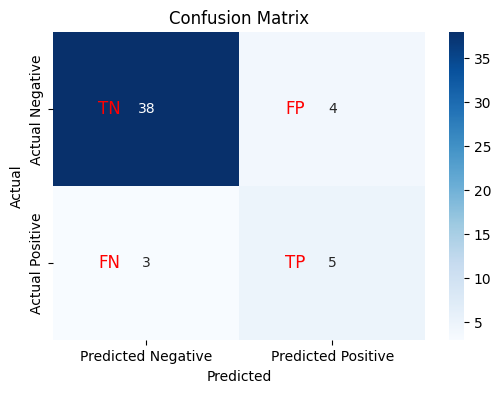

In [29]:
 # Which can be presented as

from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(actual,y_pred)
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"],
                 yticklabels=["Actual Negative", "Actual Positive"])

# Add TP, FP, TN, FN text
ax.text(0.3, 0.5, "TN", ha="center", va="center", color="red", fontsize=12)
ax.text(1.3, 0.5, "FP", ha="center", va="center", color="red", fontsize=12)
ax.text(0.3, 1.5, "FN", ha="center", va="center", color="red", fontsize=12)
ax.text(1.3, 1.5, "TP", ha="center", va="center", color="red", fontsize=12)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


From the above we can derive


#### **1.Misclassification Rate**- Answer how often is the model wrong?


$$ = \frac{\text{FN} + \text{FP}} {\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$$

In [30]:
# Calculate the error rate
error_rate = (fn + fp) / (tp + tn + fp + fn)
print(f"Misclassification Rate: {error_rate}")


Misclassification Rate: 0.14


#### **2 Recall or Sensitivity/ True Positive rate (TPR)**

 When its actually Yes, how often does it predict yes,It the ability of the model to capture all positive case

Focus: It answers the question: "*Of all the actual positives, how many did the model correctly identify*?



$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$


**When to focus on Recall**

When false negatives are costly or harmful. For example:

- Detecting cancer (missing a positive case could have severe consequences).
- Fraud detection (failing to detect a fraudulent transaction could be critical).

In [31]:
# Calculate Recall
recall = tp / (tp + fn)
print(f"Recall: {recall}")


Recall: 0.625


#### 3. **Precision** -  

*Of all the positive predictions made by the model, how many are actually corrects* , how often is it correct?


$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$


**When to focus on Precision:**

When false positives are costly or harmful. **For example**:

- Identifying spam emails (you don't want non-spam emails classified as spam).
- Medical diagnosis (minimizing false positive results to avoid unnecessary treatment).

In [32]:
# Calculate Precision
precision = tp / (tp + fp)
print(f"Precision: {precision}")


Precision: 0.5555555555555556


#### 4. **Specificity**  (also known as the **True Negative Rate**)

It answers the question:

"Of all the actual negative cases, how many did the model correctly classify?

$$
\text{Specificity} = \frac{\text{TN}}{\text{FP} + \text{TN}}
$$


In [33]:
# Calculate Specificity
specificity = tn / (fp + tn)
print(f"Specificity: {specificity}")


Specificity: 0.9047619047619048


#### **5. ROC (Receiver Operating Characteristic) Curve.**

 The ROC Curve is a graphical representation of a classification model's performance across different threshold values.

 It shows the trade-off between the **True Positive Rate** and the **False Positive Rate** as the classification threshold varies


$$
\text{X-axis: False Positive Rate (FPR)} = \frac{\text{FP}}{\text{FP} + \text{TN}}$$

$$\text{Y-axis: True Positive Rate (TPR or Recall)} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$


In [42]:
y_pred_proba =   boosting_clf.predict_proba(X_test)[:,1]
y_pred_df    = pd.DataFrame(y_pred_proba[1:51],columns=['y_pred_proba'])

In [43]:
res_df_roc = pd.concat([res_df,y_pred_df],axis=1)
res_df_roc.head(5)


,Actual,Predicted,verdict,y_pred_proba
0,0,0,Correct,0.170351
1,0,0,Correct,0.019596
2,0,0,Correct,0.421812
3,0,0,Correct,0.030590
4,1,1,Correct,0.763245


In [46]:
# Lets set several  set several theresholds


def get_confusion_matrix(threshold, df):

    df["Predicted_Label"] = (df["y_pred_proba"] >= threshold).astype(int)

    # True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)

    TP = len(df[(df["Actual"] == 1) & (df["Predicted_Label"] == 1)])
    FP = len(df[(df["Actual"] == 0) & (df["Predicted_Label"] == 1)])
    TN = len(df[(df["Actual"] == 0) & (df["Predicted_Label"] == 0)])
    FN = len(df[(df["Actual"] == 1) & (df["Predicted_Label"] == 0)])

    # True Positive Rate (TPR) and False Positive Rate (FPR)
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

    return TPR, FPR



In [53]:
thresholds = [0.9, 0,7, 0.8, 0.6,0.5, 0.4,0.3, 0.2, 0.1,0.0]

results = []

# Loop through each threshold and calculate TPR and FPR

for threshold in thresholds:
    TPR, FPR = get_confusion_matrix(threshold, res_df_roc)
    results.append({"Threshold": threshold, "TPR": TPR, "FPR": FPR})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df

,Threshold,TPR,FPR
0,0.9,0.000,0.000000
1,0.0,1.000,1.000000
2,7.0,0.000,0.000000
3,0.8,0.250,0.023810
4,0.6,0.625,0.095238
5,0.5,0.625,0.095238
6,0.4,0.625,0.142857
7,0.3,0.750,0.190476
8,0.2,1.000,0.214286
9,0.1,1.000,0.357143


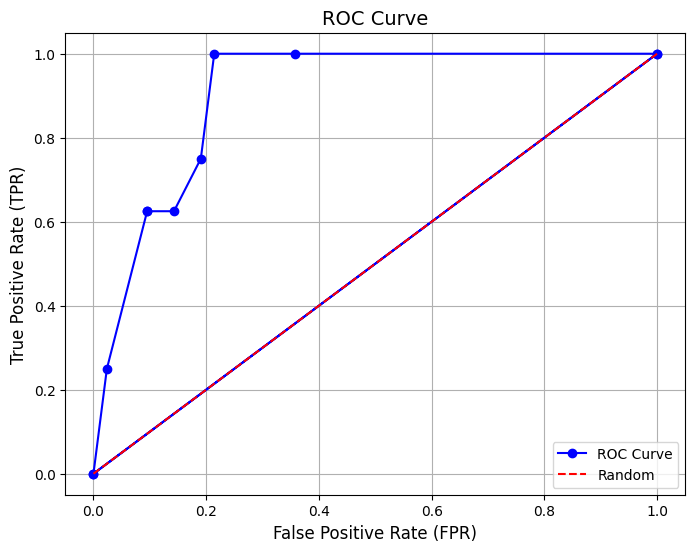

In [54]:
plt.figure(figsize=(8, 6))

plt.plot(results_df['FPR'], results_df['TPR'], marker='o', color='b', label='ROC Curve')

plt.title('ROC Curve', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')

plt.legend(loc='lower right')

# Show plot
plt.grid(True)

$$\text{AUC}=\frac{1}{2} \times (FPR_2 - FPR_1) \times (TPR_2 + TPR_1)$$


In [55]:
# Sort the data by False Positive Rate (FPR) in ascending order for proper calculation
sorted_indices  = np.argsort(results_df['FPR'])
tpr_sorted      = np.array(results_df['TPR'])[sorted_indices]
fpr_sorted      = np.array(results_df['FPR'])[sorted_indices]

# Calculate the ROC AUC score using trapezoidal rule
roc_auc = np.trapz(tpr_sorted, fpr_sorted)

roc_auc

0.9032738095238095

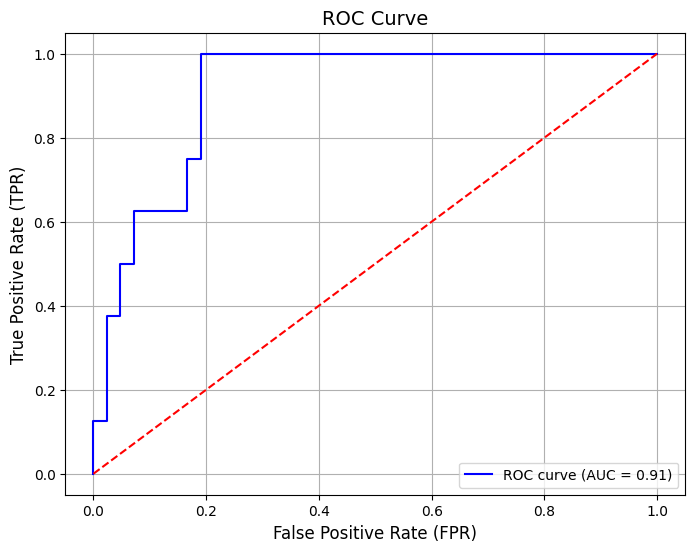

In [59]:
from sklearn.metrics import roc_curve , auc


# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(actual, y_pred_df)
roc_auc = auc(fpr, tpr)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

7. Precision & Recall Curve

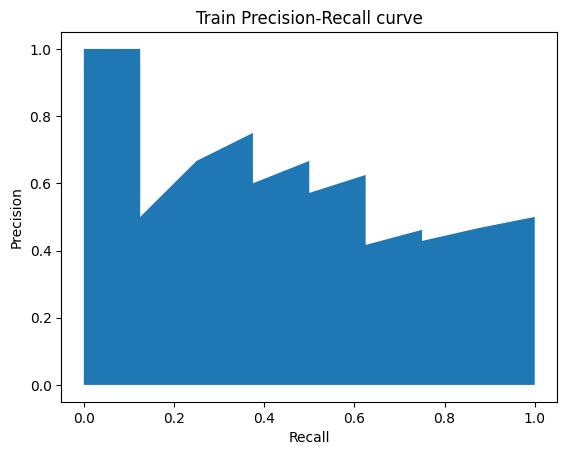

In [67]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(actual, y_pred_df)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve");

In [97]:
res_df.columns

Index(['Actual', 'Predicted', 'verdict'], dtype='object')

In [98]:
from sklearn.metrics import classification_report

print(classification_report(res_df.Actual, res_df.Predicted))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92        42
           1       0.56      0.62      0.59         8

    accuracy                           0.86        50
   macro avg       0.74      0.76      0.75        50
weighted avg       0.87      0.86      0.86        50



Precision: This measures the accuracy of the positive predictions (how many of the predicted positives were actually positive). It's calculated as:

Precision

- For class 0: 0.93 – 93% of the predicted class 0 labels were correct.
- For class 1: 0.56 – 56% of the predicted class 1 labels were correct.

---
---

Recall: This measures how well the model identifies the actual positives (how many of the actual positives were correctly identified). It's calculated as:


Recall


- For class 0: 0.90 – 90% of the actual class 0 labels were correctly identified.
- For class 1: 0.62 – 62% of the actual class 1 labels were correctly identified.